# Figure 11: Stellar Mass and Star Formation Rate Prediction Comparison

This notebook compares predictions of stellar mass (SM) and star formation rate (SFR) between UMAP-based k-nearest neighbors and autoencoder predictions.

**Two 6-panel figures are generated:**
1. **Stellar Mass Prediction Comparison**
2. **Star Formation Rate Prediction Comparison**

**Each figure shows:**
- **Top row:** UMAP-based kNN predictions (with optimized k)
- **Bottom row:** Autoencoder predictions
- **Columns:** Squared Error scatter, Mean Squared Error grid, Average SFHs reference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import sys
import pickle
import cmasher as cmr
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold

# Add src to path
sys.path.append('../src')

from utils.analysis import (sim_name, colors, times, boxing, 
                           P_x_s, P_s_x)
from utils.data_processing import load_autoencoder_data
from utils.plotting import (plot_points, plot_averages, 
                           draw_battleship_grid, draw_grid_D)

# LaTeX font setup
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline

## Load Data

In [2]:
# Load processed simulation data
with open('../data/sim_data_processed.pkl', 'rb') as f:
    sim_data = pickle.load(f)

# Load UMAP embeddings
combined_labels = np.load('../data/combined_labels.npy')
embedding = np.load('../data/umap_embedding.npy')
combined_sfh = np.load('../data/combined_sfh.npy')

# Reconstruct UMAP embeddings by simulation
for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        sim_data[sim]['umap'] = embedding[sim_mask]

print("Loaded UMAP data by simulation:")
for sim in sim_name:
    if sim_data[sim] is not None:
        print(f"{sim:>15s}: {sim_data[sim]['umap'].shape[0]:>8,d} galaxies")

Loaded UMAP data by simulation:
          EAGLE:    7,445 galaxies
      Illustris:   19,354 galaxies
   IllustrisTNG:   12,220 galaxies
         Mufasa:    1,900 galaxies
          Simba:    1,982 galaxies
         SC-SAM:   12,821 galaxies
UniverseMachine:    7,361 galaxies


In [3]:
# Load autoencoder predictions
ae_data = load_autoencoder_data(sim_data)

print("Loaded autoencoder data.")

Loaded predictions_sfh.npy: shape (63083, 139)
Loaded predictions_sfh_w.npy: shape (63083, 139)
Loaded predictions_sfr.npy: shape (63083, 2)
Loaded predictions_sfr_w.npy: shape (63083, 2)
Loaded predictions_sim.npy: shape (63083, 7)
Loaded predictions_sim_w.npy: shape (63083, 7)
Reordering predictions from sim_name_z to sim_name order...
Reordered predictions_sfh: shape (63083, 139)
Reordered predictions_sfh_w: shape (63083, 139)
Reordered predictions_sfr: shape (63083, 2)
Reordered predictions_sfr_w: shape (63083, 2)
Reordered predictions_sim: shape (63083, 7), columns reordered to sim_name
Reordered predictions_sim_w: shape (63083, 7), columns reordered to sim_name
Split EAGLE: 7445 galaxies
Split Illustris: 19354 galaxies
Split IllustrisTNG: 12220 galaxies
Split Mufasa: 1900 galaxies
Split Simba: 1982 galaxies
Split SC-SAM: 12821 galaxies
Split UniverseMachine: 7361 galaxies
Loaded autoencoder data.


In [4]:
# Create battleship grid structure
result = np.column_stack((embedding, combined_labels))
umaps = boxing(result[:,0], result[:,1], result)

print("Created battleship grid (10x10):")
non_empty_cells = sum(1 for i in range(10) for j in range(10) if umaps[i,j].shape[0] > 0)
print(f"  Non-empty grid cells: {non_empty_cells}/100")

# Calculate average SFH percentiles per grid cell
avg_sfh = boxing(x=embedding[:,0], y=embedding[:,1], z=combined_sfh, q=[16,50,84])

print(f"\nCalculated average SFHs per cell: shape {avg_sfh.shape}")

Created battleship grid (10x10):
  Non-empty grid cells: 69/100

Calculated average SFHs per cell: shape (10, 10, 3, 136)


## Extract True SM and SFR Values

In [5]:
# Combine true values from all simulations (z=0)
true_sm = []
true_sfr = []

for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        # Get z=0 values (last column)
        true_sm.extend(sim_data[sim]['sm'])  
        true_sfr.extend(sim_data[sim]['sfh_raw'][:, -1])

true_logsm = np.log10(np.array(true_sm))
true_logsfr = np.log10(np.array(true_sfr) + 1e-3)  # Avoid log(0)

print(f"Extracted true values for {len(true_sm):,} galaxies")
print(f"logSM range: {np.min(true_logsm):.2f} to {np.max(true_logsm):.2f} [log(M☉)]")
print(f"logSFR range: {np.min(true_logsfr):.2f} to {np.max(true_logsfr):.2f} [log(M☉/yr)]")

Extracted true values for 63,083 galaxies
logSM range: 9.00 to 12.57 [log(M☉)]
logSFR range: -3.00 to 1.90 [log(M☉/yr)]


## Optimize k using Cross-Validation

In [6]:
# Define k values to test
k_values = [1, 2, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 500, 750, 1000]

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Optimizing k using 5-fold cross-validation...")
print("Testing k values:", k_values)

Optimizing k using 5-fold cross-validation...
Testing k values: [1, 2, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 500, 750, 1000]


In [7]:
# Find optimal k for SM
print("\nOptimizing k for Stellar Mass predictions...")
cv_scores_sm = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, embedding, true_logsm, cv=cv, 
                            scoring='neg_mean_squared_error', n_jobs=-1)
    mse = -scores.mean()
    cv_scores_sm.append(mse)
    print(f"k={k:3d}: MSE = {mse:.4f} ± {scores.std():.4f}")

optimal_k_sm = k_values[np.argmin(cv_scores_sm)]
print(f"\nOptimal k for SM: {optimal_k_sm} (MSE = {min(cv_scores_sm):.4f})")


Optimizing k for Stellar Mass predictions...
k=  1: MSE = 0.5795 ± 0.0090
k=  2: MSE = 0.4455 ± 0.0088
k=  5: MSE = 0.3615 ± 0.0058
k= 10: MSE = 0.3306 ± 0.0050
k= 20: MSE = 0.3128 ± 0.0043
k= 30: MSE = 0.3061 ± 0.0039
k= 50: MSE = 0.3003 ± 0.0035
k= 75: MSE = 0.2974 ± 0.0034
k=100: MSE = 0.2959 ± 0.0034
k=150: MSE = 0.2943 ± 0.0033
k=200: MSE = 0.2936 ± 0.0034
k=300: MSE = 0.2930 ± 0.0034
k=500: MSE = 0.2926 ± 0.0034
k=750: MSE = 0.2928 ± 0.0034
k=1000: MSE = 0.2930 ± 0.0034

Optimal k for SM: 500 (MSE = 0.2926)


In [8]:
# Find optimal k for SFR
print("\nOptimizing k for Star Formation Rate predictions...")
cv_scores_sfr = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, embedding, true_logsfr, cv=cv, 
                            scoring='neg_mean_squared_error', n_jobs=-1)
    mse = -scores.mean()
    cv_scores_sfr.append(mse)
    print(f"k={k:3d}: MSE = {mse:.4f} ± {scores.std():.4f}")

optimal_k_sfr = k_values[np.argmin(cv_scores_sfr)]
print(f"\nOptimal k for SFR: {optimal_k_sfr} (MSE = {min(cv_scores_sfr):.4f})")


Optimizing k for Star Formation Rate predictions...
k=  1: MSE = 1.3698 ± 0.0283
k=  2: MSE = 1.0618 ± 0.0161
k=  5: MSE = 0.8627 ± 0.0137
k= 10: MSE = 0.7884 ± 0.0103
k= 20: MSE = 0.7471 ± 0.0086
k= 30: MSE = 0.7324 ± 0.0081
k= 50: MSE = 0.7190 ± 0.0080
k= 75: MSE = 0.7113 ± 0.0078
k=100: MSE = 0.7079 ± 0.0078
k=150: MSE = 0.7045 ± 0.0074
k=200: MSE = 0.7027 ± 0.0077
k=300: MSE = 0.7010 ± 0.0078
k=500: MSE = 0.7001 ± 0.0078
k=750: MSE = 0.7004 ± 0.0080
k=1000: MSE = 0.7008 ± 0.0080

Optimal k for SFR: 500 (MSE = 0.7001)


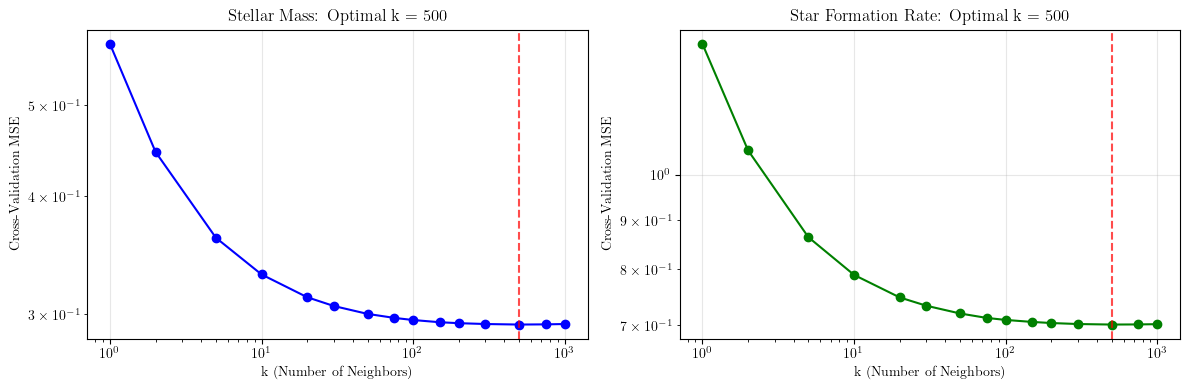

Cross-validation optimization complete!


In [9]:
# Plot CV curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.loglog(k_values, cv_scores_sm, 'o-', color='blue', markersize=6)
ax1.axvline(optimal_k_sm, color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('k (Number of Neighbors)')
ax1.set_ylabel('Cross-Validation MSE')
ax1.set_title(f'Stellar Mass: Optimal k = {optimal_k_sm}')
ax1.grid(True, alpha=0.3)

ax2.loglog(k_values, cv_scores_sfr, 'o-', color='green', markersize=6)
ax2.axvline(optimal_k_sfr, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('k (Number of Neighbors)')
ax2.set_ylabel('Cross-Validation MSE')
ax2.set_title(f'Star Formation Rate: Optimal k = {optimal_k_sfr}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Cross-validation optimization complete!")

## Train Final kNN Models with Optimal k

In [10]:
from sklearn.model_selection import KFold, LeaveOneOut

def knn_cv_predict(knn, X, y, cv_type='kfold', n_splits=5):
    if cv_type == 'kfold':
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    elif cv_type == 'loocv':
        cv = LeaveOneOut()
    else:
        raise ValueError("cv_type must be 'kfold' or 'loocv'")

    preds = np.zeros(len(y))
    for train_idx, test_idx in cv.split(X):
        knn.fit(X[train_idx], y[train_idx])
        preds[test_idx] = knn.predict(X[test_idx])
    return preds

print(f"Training kNN models with optimal k values using cross-validation predictions...")
print(f"SM: k = {optimal_k_sm}")
print(f"SFR: k = {optimal_k_sfr}")

knn_sm = KNeighborsRegressor(n_neighbors=optimal_k_sm, weights='distance')
knn_sfr = KNeighborsRegressor(n_neighbors=optimal_k_sfr, weights='distance')

# Choose CV type: 'kfold' or 'loocv'
cv_type = 'kfold'  # or 'loocv'
n_splits = 5       # Only used for kfold

pred_sm_umap = knn_cv_predict(knn_sm, embedding, true_logsm, cv_type=cv_type, n_splits=n_splits)
pred_sfr_umap = knn_cv_predict(knn_sfr, embedding, true_logsfr, cv_type=cv_type, n_splits=n_splits)

print("kNN cross-validated predictions generated.")

Training kNN models with optimal k values using cross-validation predictions...
SM: k = 500
SFR: k = 500
kNN cross-validated predictions generated.


In [11]:
# Calculate squared errors
se_sm_umap = (pred_sm_umap - true_logsm) ** 2
se_sfr_umap = (pred_sfr_umap - true_logsfr) ** 2

# Print overall performance
print(f"\nUMAP-kNN Performance:")
print(f"  SM MSE:  {np.mean(se_sm_umap):.4f}")
print(f"  SM RMSE: {np.sqrt(np.mean(se_sm_umap)):.4f}")
print(f"  SFR MSE:  {np.mean(se_sfr_umap):.4f}")
print(f"  SFR RMSE: {np.sqrt(np.mean(se_sfr_umap)):.4f}")


UMAP-kNN Performance:
  SM MSE:  0.2926
  SM RMSE: 0.5409
  SFR MSE:  0.7001
  SFR RMSE: 0.8367


## Process Autoencoder Predictions

In [12]:
# Extract autoencoder predictions
print("Processing autoencoder predictions...")

# Use unweighted predictions for direct comparison
pred_sm_ae = ae_data['predictions_sfr'][:, 0]  # log(SM)
pred_sfr_ae = ae_data['predictions_sfr'][:, 1]  # log(SFR)

# Calculate squared errors
se_sm_ae = (pred_sm_ae - true_logsm) ** 2
se_sfr_ae = (pred_sfr_ae - true_logsfr) ** 2

# Print overall performance
print(f"\nAutoencoder Performance:")
print(f"  SM MSE:  {np.mean(se_sm_ae):.4f}")
print(f"  SM RMSE: {np.sqrt(np.mean(se_sm_ae)):.4f}")
print(f"  SFR MSE:  {np.mean(se_sfr_ae):.4f}")
print(f"  SFR RMSE: {np.sqrt(np.mean(se_sfr_ae)):.4f}")

# Performance comparison
print(f"\nPerformance Comparison (RMSE):")
sm_improvement = (np.sqrt(np.mean(se_sm_umap)) - np.sqrt(np.mean(se_sm_ae))) / np.sqrt(np.mean(se_sm_umap)) * 100
sfr_improvement = (np.sqrt(np.mean(se_sfr_umap)) - np.sqrt(np.mean(se_sfr_ae))) / np.sqrt(np.mean(se_sfr_umap)) * 100
print(f"  SM: Autoencoder {'improvement' if sm_improvement > 0 else 'degradation'}: {abs(sm_improvement):.1f}%")
print(f"  SFR: Autoencoder {'improvement' if sfr_improvement > 0 else 'degradation'}: {abs(sfr_improvement):.1f}%")

Processing autoencoder predictions...

Autoencoder Performance:
  SM MSE:  0.1092
  SM RMSE: 0.3305
  SFR MSE:  2.1540
  SFR RMSE: 1.4676

Performance Comparison (RMSE):
  SM: Autoencoder improvement: 38.9%
  SFR: Autoencoder degradation: 75.4%


## kNN Verification

Run kNN procedure over autoencoder predictions, compare results to original

In [13]:
# Define k values to test
k_values = [1, 2, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 500, 750, 1000]

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Optimizing k using 5-fold cross-validation...")
print("Testing k values:", k_values)

Optimizing k using 5-fold cross-validation...
Testing k values: [1, 2, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 500, 750, 1000]


In [14]:
# Find optimal k for SM
print("\nOptimizing k for Stellar Mass predictions...")
cv_scores_sm = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, embedding, pred_sm_ae, cv=cv, 
                            scoring='neg_mean_squared_error', n_jobs=-1)
    mse = -scores.mean()
    cv_scores_sm.append(mse)
    print(f"k={k:3d}: MSE = {mse:.4f} ± {scores.std():.4f}")

optimal_k_sm = k_values[np.argmin(cv_scores_sm)]
print(f"\nOptimal k for SM: {optimal_k_sm} (MSE = {min(cv_scores_sm):.4f})")


Optimizing k for Stellar Mass predictions...
k=  1: MSE = 0.4378 ± 0.0060
k=  2: MSE = 0.3371 ± 0.0029
k=  5: MSE = 0.2738 ± 0.0053
k= 10: MSE = 0.2506 ± 0.0058
k= 20: MSE = 0.2372 ± 0.0059
k= 30: MSE = 0.2322 ± 0.0061
k= 50: MSE = 0.2280 ± 0.0061
k= 75: MSE = 0.2258 ± 0.0062
k=100: MSE = 0.2247 ± 0.0062
k=150: MSE = 0.2235 ± 0.0062
k=200: MSE = 0.2231 ± 0.0062
k=300: MSE = 0.2227 ± 0.0062
k=500: MSE = 0.2225 ± 0.0062
k=750: MSE = 0.2226 ± 0.0062
k=1000: MSE = 0.2228 ± 0.0062

Optimal k for SM: 500 (MSE = 0.2225)


In [15]:
# Find optimal k for SFR
print("\nOptimizing k for Star Formation Rate predictions...")
cv_scores_sfr = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, embedding, pred_sfr_ae, cv=cv, 
                            scoring='neg_mean_squared_error', n_jobs=-1)
    mse = -scores.mean()
    cv_scores_sfr.append(mse)
    print(f"k={k:3d}: MSE = {mse:.4f} ± {scores.std():.4f}")

optimal_k_sfr = k_values[np.argmin(cv_scores_sfr)]
print(f"\nOptimal k for SFR: {optimal_k_sfr} (MSE = {min(cv_scores_sfr):.4f})")


Optimizing k for Star Formation Rate predictions...
k=  1: MSE = 0.5693 ± 0.0151
k=  2: MSE = 0.4383 ± 0.0093
k=  5: MSE = 0.3545 ± 0.0081
k= 10: MSE = 0.3246 ± 0.0075
k= 20: MSE = 0.3073 ± 0.0074
k= 30: MSE = 0.3011 ± 0.0074
k= 50: MSE = 0.2956 ± 0.0075
k= 75: MSE = 0.2926 ± 0.0074
k=100: MSE = 0.2912 ± 0.0075
k=150: MSE = 0.2895 ± 0.0075
k=200: MSE = 0.2886 ± 0.0074
k=300: MSE = 0.2877 ± 0.0075
k=500: MSE = 0.2870 ± 0.0076
k=750: MSE = 0.2867 ± 0.0076
k=1000: MSE = 0.2867 ± 0.0076

Optimal k for SFR: 1000 (MSE = 0.2867)


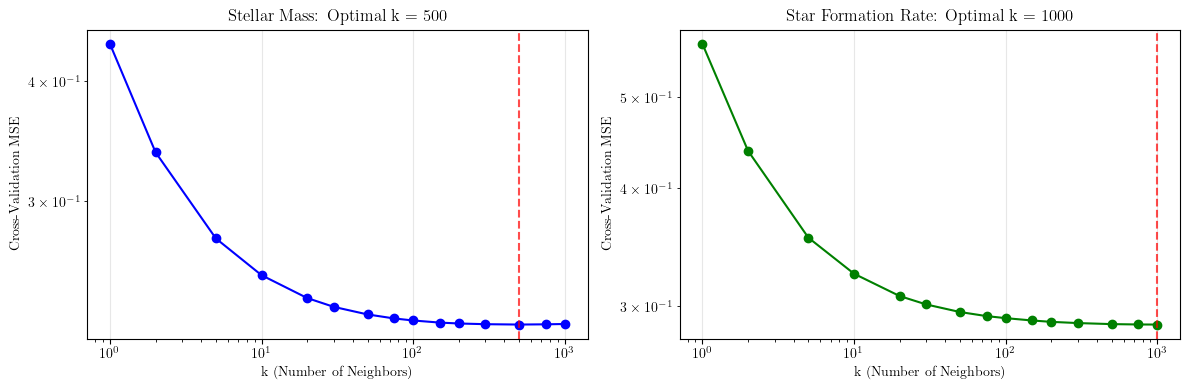

Cross-validation optimization complete!


In [16]:
# Plot CV curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.loglog(k_values, cv_scores_sm, 'o-', color='blue', markersize=6)
ax1.axvline(optimal_k_sm, color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('k (Number of Neighbors)')
ax1.set_ylabel('Cross-Validation MSE')
ax1.set_title(f'Stellar Mass: Optimal k = {optimal_k_sm}')
ax1.grid(True, alpha=0.3)

ax2.loglog(k_values, cv_scores_sfr, 'o-', color='green', markersize=6)
ax2.axvline(optimal_k_sfr, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('k (Number of Neighbors)')
ax2.set_ylabel('Cross-Validation MSE')
ax2.set_title(f'Star Formation Rate: Optimal k = {optimal_k_sfr}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Cross-validation optimization complete!")

In [17]:
from sklearn.model_selection import KFold, LeaveOneOut

def knn_cv_predict(knn, X, y, cv_type='kfold', n_splits=5):
    if cv_type == 'kfold':
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    elif cv_type == 'loocv':
        cv = LeaveOneOut()
    else:
        raise ValueError("cv_type must be 'kfold' or 'loocv'")

    preds = np.zeros(len(y))
    for train_idx, test_idx in cv.split(X):
        knn.fit(X[train_idx], y[train_idx])
        preds[test_idx] = knn.predict(X[test_idx])
    return preds

print(f"Training kNN models with optimal k values using cross-validation predictions...")
print(f"SM: k = {optimal_k_sm}")
print(f"SFR: k = {optimal_k_sfr}")

knn_sm_ae = KNeighborsRegressor(n_neighbors=optimal_k_sm, weights='distance')
knn_sfr_ae = KNeighborsRegressor(n_neighbors=optimal_k_sfr, weights='distance')

# Choose CV type: 'kfold' or 'loocv'
cv_type = 'kfold'  # or 'loocv'
n_splits = 5       # Only used for kfold

pred_sm_ae_knn = knn_cv_predict(knn_sm_ae, embedding, pred_sm_ae, cv_type=cv_type, n_splits=n_splits)
pred_sfr_ae_knn = knn_cv_predict(knn_sfr_ae, embedding, pred_sfr_ae, cv_type=cv_type, n_splits=n_splits)

print("kNN cross-validated predictions generated.")

Training kNN models with optimal k values using cross-validation predictions...
SM: k = 500
SFR: k = 1000
kNN cross-validated predictions generated.


In [18]:
# Calculate squared errors
se_sm_ae_knn = (pred_sm_ae_knn - true_logsm) ** 2
se_sfr_ae_knn = (pred_sfr_ae_knn - true_logsfr) ** 2

# Print overall performance
print(f"\nAutoencoder Performance:")
print(f"  SM MSE:  {np.mean(se_sm_ae_knn):.4f}")
print(f"  SM RMSE: {np.sqrt(np.mean(se_sm_ae_knn)):.4f}")
print(f"  SFR MSE:  {np.mean(se_sfr_ae_knn):.4f}")
print(f"  SFR RMSE: {np.sqrt(np.mean(se_sfr_ae_knn)):.4f}")

# Performance comparison
print(f"\nPerformance Comparison (RMSE):")
sm_improvement = (np.sqrt(np.mean(se_sm_umap)) - np.sqrt(np.mean(se_sm_ae_knn))) / np.sqrt(np.mean(se_sm_umap)) * 100
sfr_improvement = (np.sqrt(np.mean(se_sfr_umap)) - np.sqrt(np.mean(se_sfr_ae_knn))) / np.sqrt(np.mean(se_sfr_umap)) * 100
print(f"  SM: Autoencoder {'improvement' if sm_improvement > 0 else 'degradation'}: {abs(sm_improvement):.1f}%")
print(f"  SFR: Autoencoder {'improvement' if sfr_improvement > 0 else 'degradation'}: {abs(sfr_improvement):.1f}%")


Autoencoder Performance:
  SM MSE:  0.2945
  SM RMSE: 0.5426
  SFR MSE:  2.3710
  SFR RMSE: 1.5398

Performance Comparison (RMSE):
  SM: Autoencoder degradation: 0.3%
  SFR: Autoencoder degradation: 84.0%


## Create Gridded MSE Metrics for Visualization

In [19]:
# Grid the squared errors for visualization
print("Creating spatial grids of squared errors...")

umap_sm_mse_grid = boxing(x=embedding[:,0], y=embedding[:,1], z=se_sm_umap, average=True)
ae_sm_mse_grid = boxing(x=embedding[:,0], y=embedding[:,1], z=se_sm_ae, average=True)
umap_sfr_mse_grid = boxing(x=embedding[:,0], y=embedding[:,1], z=se_sfr_umap, average=True)
ae_sfr_mse_grid = boxing(x=embedding[:,0], y=embedding[:,1], z=se_sfr_ae, average=True)

print(f"Gridded MSE data: shape {umap_sm_mse_grid.shape}")

Creating spatial grids of squared errors...
Gridded MSE data: shape (10, 10)


c:\Users\joshs\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:101: RuntimeWarning: Mean of empty slice
  box = np.nanmean(box, axis=0)


## Generate Figure 1: Stellar Mass Prediction Comparison

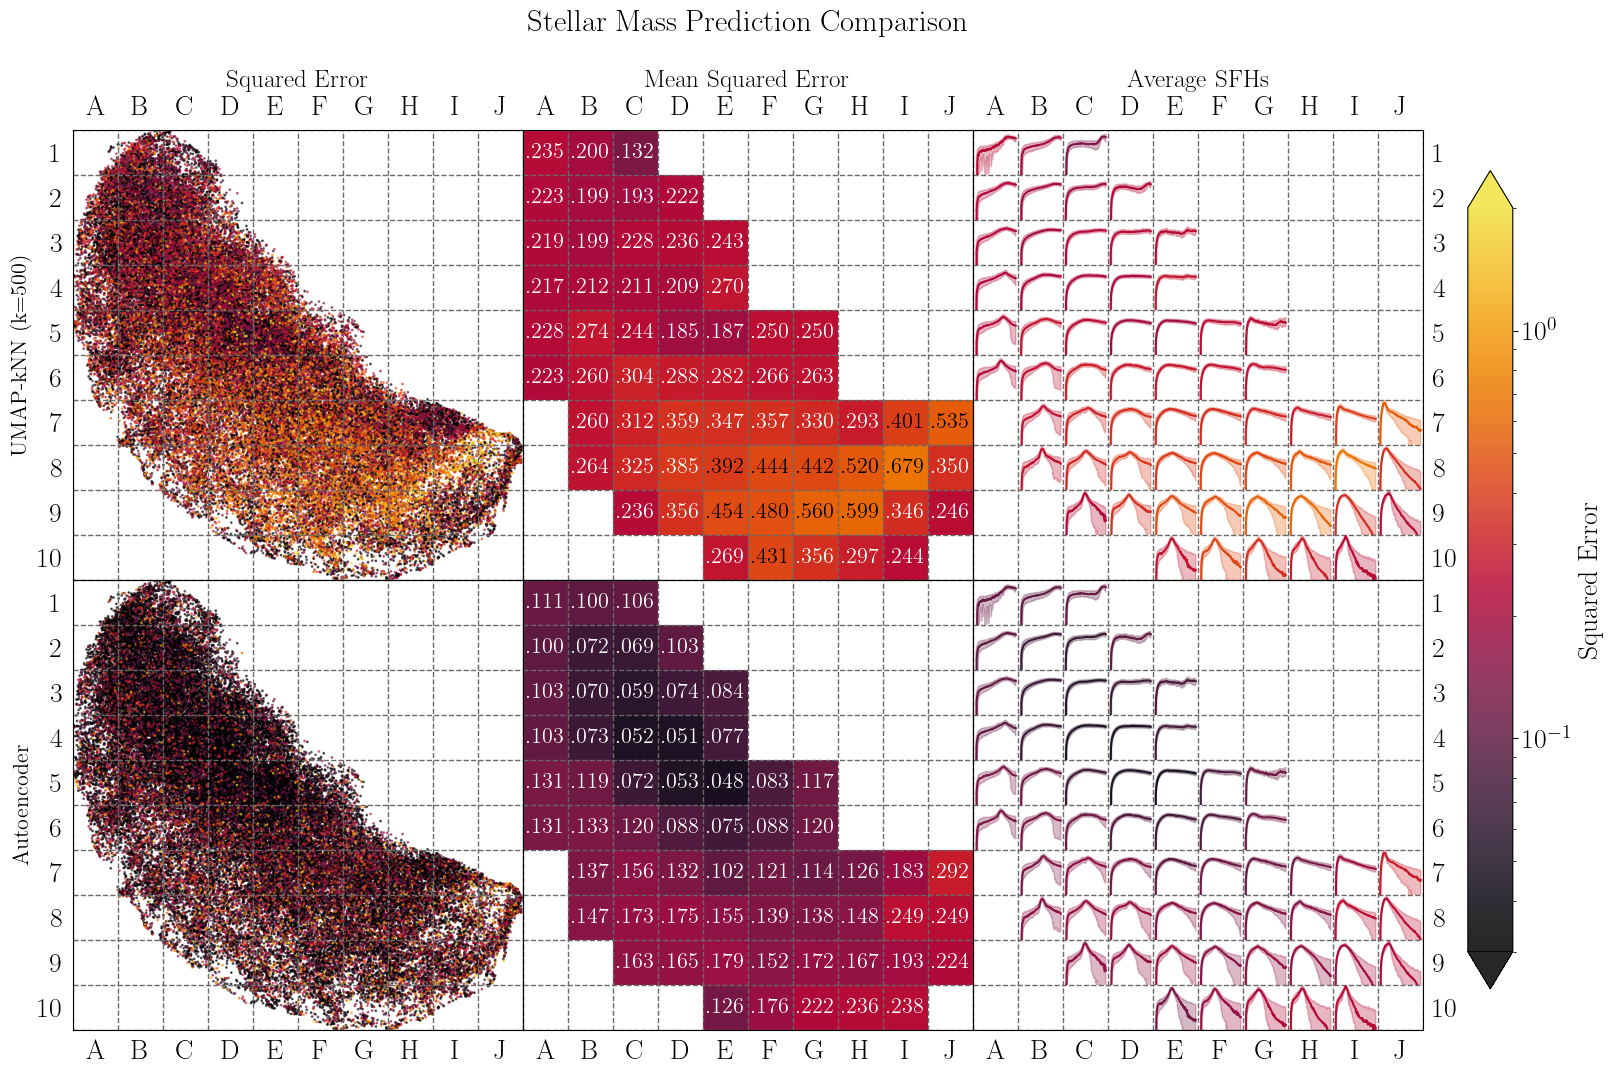

Stellar Mass prediction comparison figure generated!


In [20]:
# Set up colormap and normalization for errors
cmap = cmr.ember  # Good for error visualization
vmin, vmax = 3e-2, 2e0  # Adjust based on actual error ranges

# Create figure using draw_grid_D (2 rows x 3 columns)
fig, ax, norm = draw_grid_D(cmap=cmap, vmin=vmin, vmax=vmax, lognorm=True)

# Row 1: UMAP-kNN predictions
plot_points(x=embedding[:,0], y=embedding[:,1], z=se_sm_umap, alpha=0.6, s=1,
           fig=fig, ax=ax[0], cax=ax[-1], cmap=cmap, norm=norm, 
           extend='both', label='Squared Error')

plot_averages(umap_sm_mse_grid, avg_sfh, fig, ax[1], ax[2], umaps, cmap, norm, ftype='f', decimals=3)

# Row 2: Autoencoder predictions
plot_points(x=embedding[:,0], y=embedding[:,1], z=se_sm_ae, alpha=0.6, s=1,
           fig=fig, ax=ax[3], cax=ax[-1], cmap=cmap, norm=norm, 
           extend='both', label='Squared Error')

plot_averages(ae_sm_mse_grid, avg_sfh, fig, ax[4], ax[5], umaps, cmap, norm, ftype='f', decimals=3)

# Add row labels
ax[0].set_ylabel(f'UMAP-kNN (k={optimal_k_sm})', fontsize=16)
ax[3].set_ylabel('Autoencoder', fontsize=16)

# Add column titles
ax[0].set_title('Squared Error', fontsize=18)
ax[1].set_title('Mean Squared Error', fontsize=18)
ax[2].set_title('Average SFHs', fontsize=18)

# Add overall title
fig.suptitle('Stellar Mass Prediction Comparison', fontsize=22, y=0.78)

# Save figure
plt.savefig('../figures/sm_prediction_comparison.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/sm_prediction_comparison.pdf', bbox_inches='tight')

plt.show()
print("Stellar Mass prediction comparison figure generated!")

## Generate Figure 2: Star Formation Rate Prediction Comparison

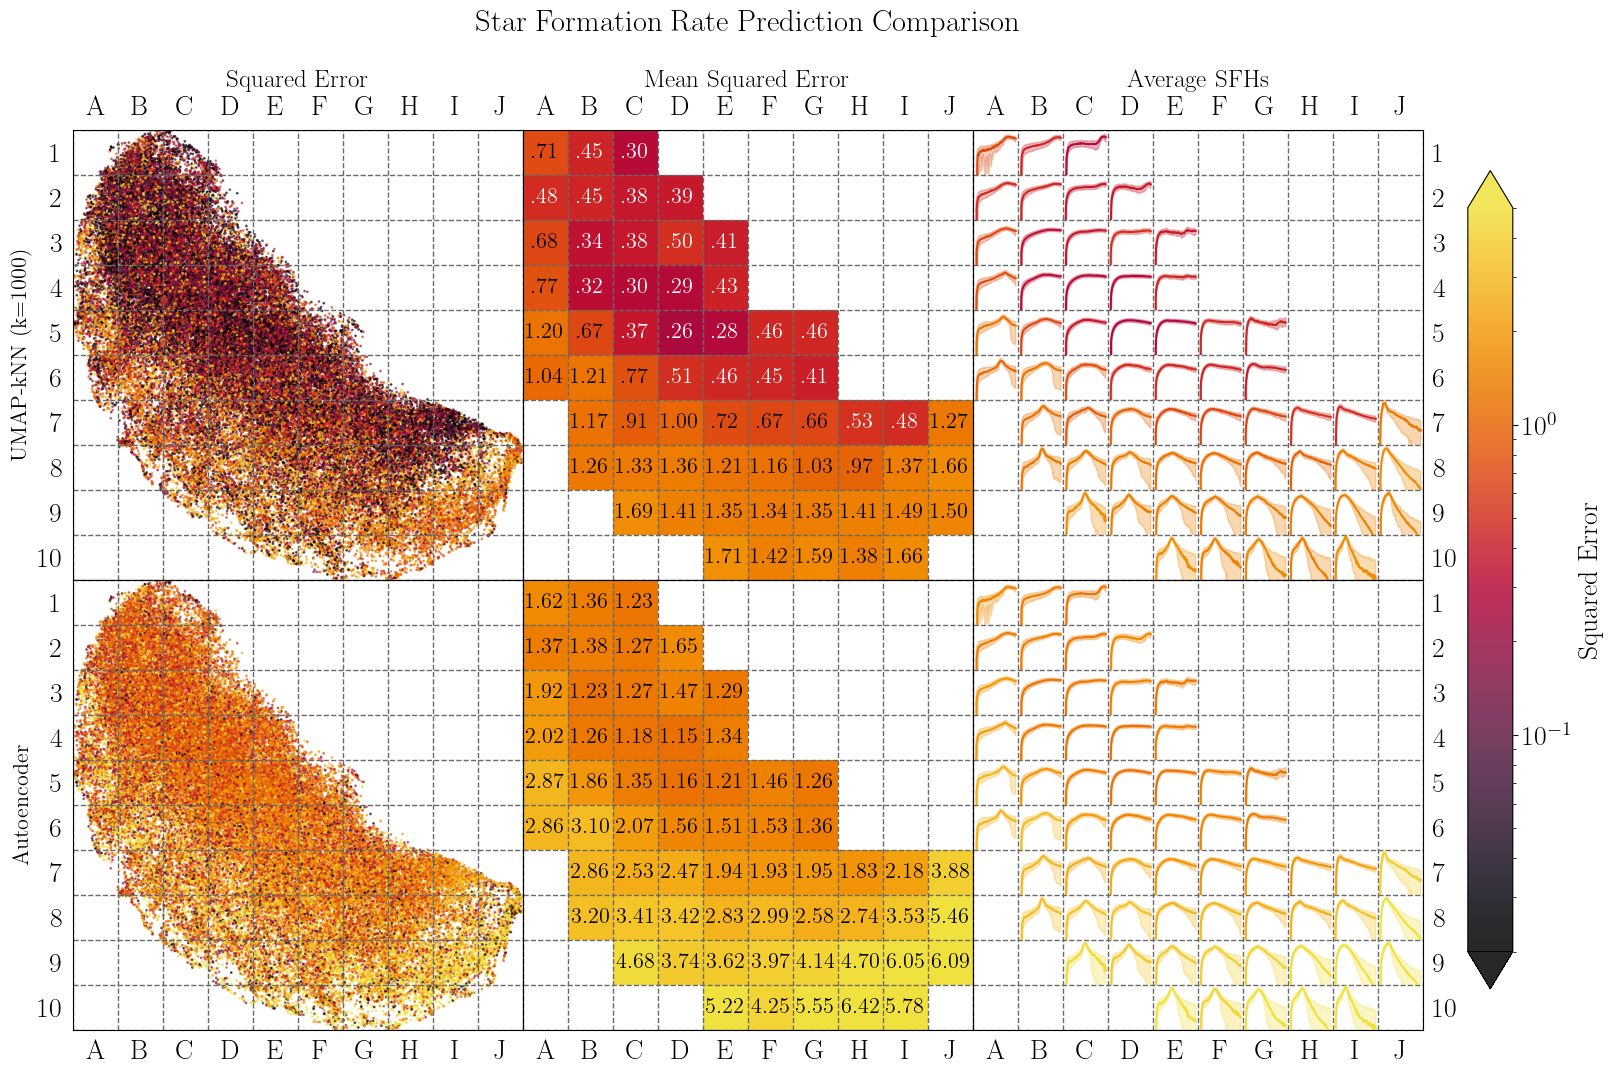

Star Formation Rate prediction comparison figure generated!


In [21]:
# Set up colormap and normalization for errors
cmap = cmr.ember  # Good for error visualization
vmin, vmax = 2e-2, 5e0  # Adjust based on actual error ranges

# Create figure using draw_grid_D (2 rows x 3 columns)
fig, ax, norm = draw_grid_D(cmap=cmap, vmin=vmin, vmax=vmax, lognorm=True)

# Row 1: UMAP-kNN predictions
plot_points(x=embedding[:,0], y=embedding[:,1], z=se_sfr_umap, alpha=0.6, s=1,
           fig=fig, ax=ax[0], cax=ax[-1], cmap=cmap, norm=norm, 
           extend='both', label='Squared Error')

plot_averages(umap_sfr_mse_grid, avg_sfh, fig, ax[1], ax[2], umaps, cmap, norm, ftype='f', decimals=2)

# Row 2: Autoencoder predictions
plot_points(x=embedding[:,0], y=embedding[:,1], z=se_sfr_ae, alpha=0.6, s=1,
           fig=fig, ax=ax[3], cax=ax[-1], cmap=cmap, norm=norm, 
           extend='both', label='Squared Error')

plot_averages(ae_sfr_mse_grid, avg_sfh, fig, ax[4], ax[5], umaps, cmap, norm, ftype='f', decimals=2)

# Add row labels
ax[0].set_ylabel(f'UMAP-kNN (k={optimal_k_sfr})', fontsize=16)
ax[3].set_ylabel('Autoencoder', fontsize=16)

# Add column titles
ax[0].set_title('Squared Error', fontsize=18)
ax[1].set_title('Mean Squared Error', fontsize=18)
ax[2].set_title('Average SFHs', fontsize=18)

# Add overall title
fig.suptitle('Star Formation Rate Prediction Comparison', fontsize=22, y=0.78)

# Save figure
plt.savefig('../figures/sfr_prediction_comparison.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/sfr_prediction_comparison.pdf', bbox_inches='tight')

plt.show()
print("Star Formation Rate prediction comparison figure generated!")